In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from enum import Enum

# General Scientific Constants
class universalConstants(float, Enum):
    charge = 1.602 * (1.0e-19)
    """
    single unit of charge of elctron / proton
    """

    h = 6.626 * (1.0e-34)
    """
    Plank's Constant 
    """

    c = 2.997 * (1.0e+8)
    """
    Speed of light in vacuum 
    """

In [3]:
def pulse_function(t_values, first_pulse_center_time, W_pulse, pulse_width_param):
    """
    Generates a periodic pulse.

    Args:
        t_values (np.ndarray or float): Time values.
        first_pulse_center_time (float): Center time of the first pulse.
        W_pulse (float): Angular frequency of pulse repetition.
        pulse_width_param (float): 'Width' parameter for individual pulses.
    Returns:
        np.ndarray or float: The amplitude of the periodi pulse.

    Raises:
        ValueError: If W_pulse is non-positive or pulse_width_param is zero.
    """
    if pulse_width_param == 0:
        return (np.inf * np.ones_like(t_values) if isinstance(t_values, np.ndarray) else np.inf)
    W_pulse = np.abs(W_pulse)

    T_pulse = 2 * np.pi / W_pulse
    t_relative_to_first_center = t_values - first_pulse_center_time
    t_relative_to_nearest_center = (t_relative_to_first_center + T_pulse / 2) % T_pulse - T_pulse / 2
    pulse_argument = t_relative_to_nearest_center / pulse_width_param

    return np.exp(-0.5 * pulse_argument ** 2)   # gaussian pulse
    return np.sinc(pulse_argument)              # sinc pulse

#### Parameters required for numerical analysis
Macroscopic Laser model\
[laser dynamics and optical injection lock.pdf](./laser%20dynamics%20and%20optical%20injection%20lock.pdf) Pg 31

In [4]:
# Specific Constants (all in SI units)

Tau_n = 0.74 * (1.0e-9)
""" Carrier lifetime (seconds) """

Tau_p = 0.74 * (1.0e-12)
""" Photon lifetime (seconds) """

g = 1.27 * (1.0e-12)
""" Differential gain coefficient (m^3 seconds^-1) """

Epsilon = 1.18 * (1.0e-23)    
""" Gain Compression factor (m^3) """

N_transparent = 0.85 * (1.0e+24)         
""" Carrier density at transparency (m^-3) """

Beta = 0.5 * (1.0e-5)         
""" Spontaneous enhancement factor """

Alpha = 2.7                 
""" Linewidth sample enhancement factor """

Eta = 0.2                   
""" Differential quantum efficiency """

Vol = 1.72 * (1.0e-17)          
""" Active layer volume (m^3) """

Gamma_cap = 0.27            
""" Mode confinement factor """

Kappa = 1.13 * (1.0e+11)      
""" OIL coupling term (Hz) """

Laser_freq = universalConstants.c.value / (1550 * 1e-9)
""" free running frequency """

I_th = universalConstants.charge.value * Vol / Tau_n * (N_transparent  + 1 / (g * Gamma_cap * Tau_p))
""" Threshold Current for Lasing """

err_fault = 1e-6

### Laser Rate equations
The dynamics of semiconductor laser is described by system of rate equations. In
general this system includes terms for carriers N, photon density S, and optical
phase ϕ: Pg 28

In [5]:
class Laser:
    """
    Laser class for simulations
    """

    def __init__(self, fr_freq = 0.0, N0 = N_transparent, S0 = err_fault, Phi0 = err_fault):
        self.N0 = N0
        self.S0 = S0
        self.Phi0 = Phi0

        self.fr_freq = fr_freq
        """
        free running frequency
        """

        self.stable = False

        self.N_t = self.N0
        """
        Number of Carriers
        """

        self.S_t = self.S0
        """
        Photon density
        """

        self.Phi_t = self.Phi0
        """
        Optical phase
        """
    
    def values(self):
        """
        Physical constraint check and get values
        """
        self.N_t = max(err_fault, self.N_t)
        self.S_t = max(err_fault, self.S_t)

        return (self.N_t, self.S_t, self.Phi_t)

    ###### Approximations #######
    def set_steadystate(self, Coeffs_N, Coeffs_S, Coeffs_Phi, W_drive = 0.0):
        self.stable = True
        
        self.Coeffs_N = Coeffs_N
        self.Coeffs_S = Coeffs_S  
        self.Coeffs_Phi = Coeffs_Phi

        self.W_drive = W_drive

    def steadystate_function(self, Coeffs, t, clip_val= True):
        A, B, C, phi, D, PCENTER, PWIDTH = Coeffs
        val = A + B * t + C * np.cos(self.W_drive * t + phi) + D * pulse_function(t, PCENTER, self.W_drive, PWIDTH)
        if(clip_val):
            return np.clip(val, min= 0)
        return val

    def N(self, t):
        self.N_t = self.steadystate_function(self.Coeffs_N, t)
        return self.N_t

    def S(self, t):
        self.S_t = self.steadystate_function(self.Coeffs_S, t)
        return self.S_t

    def Phi(self, t):
        self.Phi_t = self.steadystate_function(self.Coeffs_Phi, t, False)
        return self.Phi_t
    ###### ####### ####### #######

    def reset(self):
        self.N_t = self.N0
        self.S_t = self.S0
        self.Phi_t = self.Phi0

        self.stable = False

    def update(self, I_t, t, dt, Fn_t= 0.0, Fs_t= 0.0, Fphi_t= 0.0):
        """
        Update N, S, phi and return current value
        """
        if(self.stable):
            self.N(t)
            self.S(t)
            self.Phi(t)
        else:
            self.N_t += self.dN_dt(I_t, Fn_t) * dt 
            self.S_t += self.dS_dt(Fs_t) * dt
            self.Phi_t += self.dPhi_dt(Fphi_t) * dt

        return self.values()

    def dN_dt(self, I_t, Fn_t):
        """
        delta Number of Carriers
        """
        val = I_t / (universalConstants.charge.value * Vol) - self.N_t / Tau_n - g * ((self.N_t - self.N0) / (1.0 + Epsilon * self.S_t)) * self.S_t + Fn_t
        return val

    def dS_dt(self, Fs_t):
        """
        delta Photon density
        """
        val = Gamma_cap * g * ((self.N_t - self.N0) / (1.0 + Epsilon * self.S_t)) * self.S_t - self.S_t / Tau_p + Gamma_cap * Beta * self.N_t / Tau_n + Fs_t
        return val

    def dPhi_dt(self, Fphi_t):
        """
        delta Optical phase
        """
        val = (Alpha / 2.0) * (Gamma_cap * g * (self.N_t - self.N0) - 1.0 / Tau_p) + Fphi_t
        return val
    
    def Power(self, t):
        """ Power of laser """
        Pval = Vol * Eta * universalConstants.h.value * self.fr_freq / (2.0 * Gamma_cap * Tau_p)
        if(self.stable):
            return Pval * self.S(t)
        return Pval * self.S_t
    
master_laser = Laser(Laser_freq)

### Laser signal analysis
Using current driven model

In [6]:
class CurrentDriver:
    """ 
    Current Driver class
    """
    def set_Current(self, iDC= 0.0, iAC= 0.0, W_drive= 0.0, offs= 0.0, default_DC= 0.0):
        """ 
        iDC, iAC: DC, AC magnitude (Amps)\n
        W_drive, offs: AC frequency (angular freq), offset\n 
        default_DC: for off state DC
        """
        self.iDC = iDC
        self.iAC = iAC
    
        self.W_drive = W_drive
        self.offs = offs

        self.default_DC = default_DC

        self.switch_func_val = False
        self.switch_func_obj = None
        self.ON = True

    def set_switch_func(self, func_obj):
        print("Custom current switch function set")
        self.switch_func_val = True
        self.switch_func_obj = func_obj

    def I(self, t):                   
        """ 
        Driving current at t
        """
        if(self.ON):
            return self.iDC + self.iAC * np.cos(self.W_drive * t + self.offs)
        return self.default_DC
        
    def switch_func(self, t_switch, t_final):
        if(self.switch_func_val):
                twitch, self.ON = self.switch_func_obj(t_switch, t_final, self.ON)
                return twitch
        return t_switch
        

def F_Lns(t, noise_dist):        
    """ Langevin noise sources """
    pass

master_current = CurrentDriver()

In [7]:
class LaserSimulator:
    """
    Simulator Class for lasers
    """
    def __init__(self):
        self.current = []
        self.carriers = []
        self.photons = []
        self.phases = []
        self.time = []

        self.t_final = None
        self.dt = None
        self.t = 0
        self.sampling_rate = None

    def reset(self):
        self.current.clear()
        self.carriers.clear()
        self.photons.clear()
        self.phases.clear()
        self.time.clear()

        self.t = 0

    def set_Parameters(self, t_final, dt, sampling_rate= None):
        self.t_final = t_final
        self.dt = dt
        self.sampling_rate = dt

        if(sampling_rate is not None and sampling_rate < t_final and sampling_rate >= dt):
            self.sampling_rate = sampling_rate

    def simulate(self, laser_model: Laser, current_driver: CurrentDriver):
        t_switch, t_sample = 0.0, 0.0

        while(self.t < self.t_final):
            t_switch = current_driver.switch_func(t_switch, self.t_final)
            I_t = current_driver.I(self.t)
            
            (c, p, ph)= laser_model.update(I_t, self.t, self.dt)

            if(t_sample >= self.sampling_rate):
                t_sample = 0
                self.current.append(I_t)
                self.carriers.append(c)
                self.photons.append(p)
                self.phases.append(ph)
                self.time.append(self.t)

            t_switch += self.dt
            t_sample += self.dt
            self.t += self.dt
            
        print(f"No. of samples {len(self.time)}")

    def simulate_power(self, laser_model: Laser, t_final, dt):
        """ 
        Returns power output of Laser
        stablized model
        """
        if(not laser_model.stable):
            print("Unstable laser")
            return None, None

        power = []
        time = []
        t = 0
        while(t < t_final):
            power.append(laser_model.Power(t))
            time.append(t)
            t += dt
            
        print(f"No. of samples {len(time)}")
        return power, time

    def plot_data(self):
        """
        Plot the simulation data
        """

        if(len(self.time) == 0):
            print("No data to plot")
            return

        plt.figure(figsize=(12, 6)) # Create a figure for the plot

        plt.subplot(2,2,1)
        plt.plot(self.time, self.photons)
        plt.xlabel(f"time")
        plt.ylabel("photons")

        plt.subplot(2,2,2)
        plt.plot(self.time, self.current)
        plt.xlabel(f"time")
        plt.ylabel("current")

        plt.subplot(2,2,3)
        plt.plot(self.time, self.carriers)
        plt.xlabel(f"time")
        plt.ylabel("carriers")

        plt.subplot(2,2,4)
        plt.plot(self.time, self.phases)
        plt.xlabel(f"time")
        plt.ylabel("phase")

        plt.show()

    def values(self):
        """
        Returns (carriers, photons, phases and time)
        """
        return (self.carriers, self.photons, self.phases, self.time)

### Master Laser (Phase Prep Laser)
Steady state approximation simulation

In [ ]:
print(f"Threshold Current = { I_th :2.4f} Amps")
master_current.set_Current(0.032, default_DC= 0.016)

def switch_func(t_switch, t_final, current_state):
    """
    For gain switching simulation
    """
    if(t_switch > t_final / 40):
        return 0, not current_state
    return t_switch, current_state

master_current.set_switch_func(switch_func)

laser_simulator = LaserSimulator()
laser_simulator.set_Parameters(5.0e-9, 1.0e-12)
laser_simulator.simulate(master_laser, master_current)

Threshold Current = 0.0178 Amps
Custom current switch function set
No. of samples 4999


#### plots for  current driven model analysis

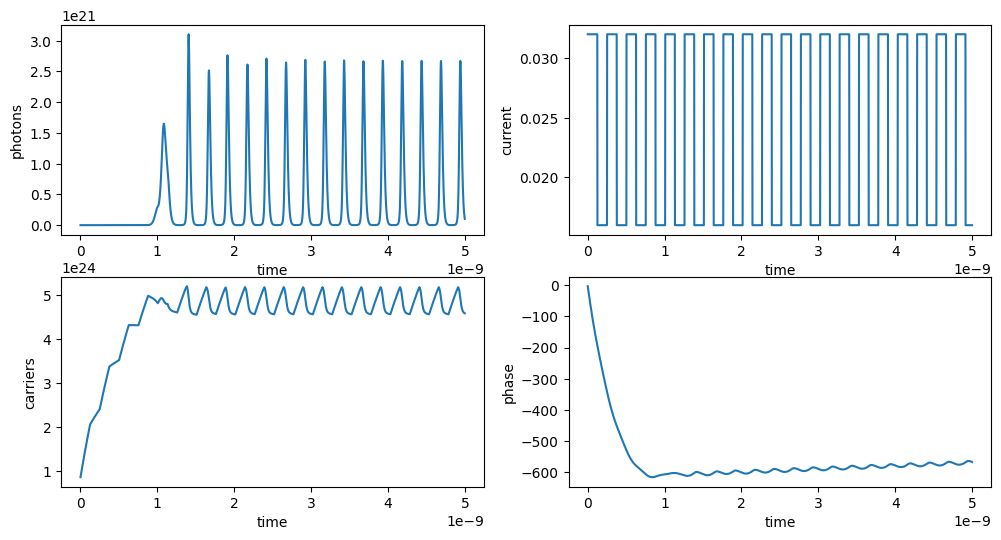

In [9]:
laser_simulator.plot_data()

#### Analysis For Steady State Approximations

In [10]:
class BaseAnalyser:
    def __init__(self):
        self.frequencies = None
        self.fft_result = None
        self.sampling_rate = None

        self.freq_max = None

    def get_Wdrive(self):
        if(self.freq_max is not None):
            return 2 * np.pi * self.freq_max

    def extract_Wdrive(self, values, sampling_rate):
        """
        Extract frequency components for analysis and approximations
        """
        # Ensure input is a NumPy 1D numpy
        signal = np.asarray(values)
        n = len(signal) # Number of samples

        # Store common properties
        self.sampling_rate = sampling_rate

        # Taking only positive frequencies for consideration
        fft_result = np.abs(np.fft.fft(signal))
        frequencies = np.fft.fftfreq(n, sampling_rate)

        fft_result[1:n//2] = fft_result[1:n//2] * 2

        # Excluding pure DC frequency
        self.fft_result = fft_result[1:n//2]
        self.frequencies = frequencies[1:n//2]

    def remove_noisyWdrive(self, amp_cutoff = 20):
        if(self.frequencies is None):
            print("No data extraction done")
            return
        
        amp_max = self.fft_result.max()
        self.freq_max = self.frequencies[self.fft_result.argmax()]

        self.frequencies = self.frequencies[self.fft_result > amp_max / amp_cutoff]
        self.fft_result = self.fft_result[self.fft_result > amp_max / amp_cutoff]

    def plot_Wdrive_Amplittude(self):
        """
        Plot magnified and normalised frequency components
        """
        if(self.frequencies is None):
            print("No data extraction done")
            return

        # --- Plot the Amplitude Spectrum ---
        plt.figure(figsize=(12, 6)) # Create a figure for the plot

        plt.plot(self.frequencies, self.fft_result / self.fft_result.max())

        fm = self.get_Wdrive()
        plt.title(f"Wdrive {"Max: " + np.format_float_scientific(fm, precision= 3, exp_digits= 3) if(fm) else ""}")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Component (normalized)")
        plt.grid(True) # Add a grid for easier reading

        # Show the plot
        plt.show()  

In [11]:
# Analysis on photons
carriers, photons, phases, _ = laser_simulator.values()

laser_analyser = BaseAnalyser()
laser_analyser.extract_Wdrive(photons, laser_simulator.sampling_rate)
#laser_analyser.plot_Wdrive_Amplittude()

In [12]:
# Print Main driving frequencies
laser_analyser.remove_noisyWdrive()
print(np.format_float_scientific(laser_analyser.get_Wdrive(), precision= 3, exp_digits= 3))
#laser_analyser.plot_Wdrive_Amplittude()

2.514e+010


#### Approximating Laser Equations 
Using Piece Wise functions to find best linear Fit\
Account for pulses taken separately\
\
*A* + *B*t + *C*cos(Wt + phi) + Pulse(t)

In [13]:
class LaserAnalyser(BaseAnalyser):
    def __init__(self):
        super().__init__()

    def approx_coefficients(self, values, clip_val= True):
        """
        A Composite function model to approximate from raw signals
        clip_val: To clip -ve as 0
        """

        if(self.freq_max is None):
            print("Approximation cannot be done, extraction and cleaning required")
            return

        W = self.get_Wdrive()

        # Ensure input is a NumPy 1D numpy
        signal = np.asarray(values)
        n_points = len(signal) # Number of samples

        t = np.arange(0, n_points * self.sampling_rate, self.sampling_rate)

        # Construct the design matrix X
        # Each column corresponds to a basis function: 1, t, cos(Wt), sin(Wt)
        X = np.vstack([
            np.ones(n_points),      # For coefficient A
            t,                      # For coefficient B
            np.cos(W * t),          # For coefficient C1
            np.sin(W * t)           # For coefficient C2
        ]).T # Transpose to get shape (n_points, 4)

        # Solve the linear least squares problem X * coeffs = data_points
        # The result 'coeffs' will be [A, B, C1, C2]
        try:
            coeffs, _, _, _ = np.linalg.lstsq(X, signal)
        except np.linalg.LinAlgError as e:
            print(f"Error during least squares fit: {e}")
            print("This might happen if your data is too short or all points are identical.")
            return None # Return None for parameters

        A, B, C1, C2 = coeffs

        # Convert C1 and C2 back to C and phi
        C = np.sqrt(C1**2 + C2**2)
        phi = np.arctan2(-C2, C1) # atan2(-Csin(phi), Ccos(phi)) = atan2(y, x)

        # Reconstruct the fitted signal
        fitted_signal = A + B * t + C * np.cos(W * t + phi)
        if(clip_val):
            fitted_signal= np.clip(fitted_signal, min= 0)

        # Pulse residuals
        residuals = signal - fitted_signal
        if(residuals.max() < 3 * fitted_signal.std()):
            return (A, B, C, phi, 0.0, 0.0, 1.0)

        print("Pulse")
        dismiss_factor = 0.25
        A, B, C = A * dismiss_factor, B * dismiss_factor, C * dismiss_factor
        if(dismiss_factor < 0.2):
            residuals = signal

        # Need to fit pulses
        TimePeriod = 1 / W
        PCENTER = t[residuals.argmax()]

        # Pulse width factor
        PWIDTH = TimePeriod * 0.25

        D = residuals.max()
        coeffs = [A, B, C, phi, D, PCENTER, PWIDTH]

        return coeffs

    def plot_approx(self, values, coeffs, clip_val= True):
        """
        Plot the approx signal output to the model equation
        """

        if(self.freq_max is None):
            print("Approximation cannot be done, extraction and cleaning required")
            return

        W = self.get_Wdrive()

        # Ensure input is a NumPy 1D numpy
        signal = np.asarray(values)
        n_points = len(signal) # Number of samples

        t = np.arange(0, n_points * self.sampling_rate, self.sampling_rate)

        A, B, C, phi, D, PCENTER, PWIDTH = coeffs

        # fitting signal
        fitted_signal = A + B * t + C * np.cos(W * t + phi) + D * pulse_function(t, PCENTER, W, PWIDTH)
        if(clip_val):
            fitted_signal = np.clip(fitted_signal,min= 0)
        residuals = signal - fitted_signal

        # --- Plotting Section (conditional) ---
        plt.figure(figsize=(12, 7))

        # Plot the original input data points
        plt.plot(t, signal, label='Input Data')
        plt.plot(t, fitted_signal, label='Approx Signal')
        #plt.plot(t, residuals, label='Residuals')

        plt.xlabel('Time (t)', fontsize=12)
        plt.ylabel('Component', fontsize=12)
        plt.grid(True)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

In [14]:
laser_analyser = LaserAnalyser()
laser_analyser.extract_Wdrive(photons, laser_simulator.sampling_rate)
laser_analyser.remove_noisyWdrive()

In [15]:
Wdrive = laser_analyser.get_Wdrive()
Coeffs_S = laser_analyser.approx_coefficients(photons)
Coeffs_N = laser_analyser.approx_coefficients(carriers)
Coeffs_Phi = laser_analyser.approx_coefficients(phases)

master_laser.set_steadystate(Coeffs_N, Coeffs_S, Coeffs_Phi, Wdrive)

Pulse


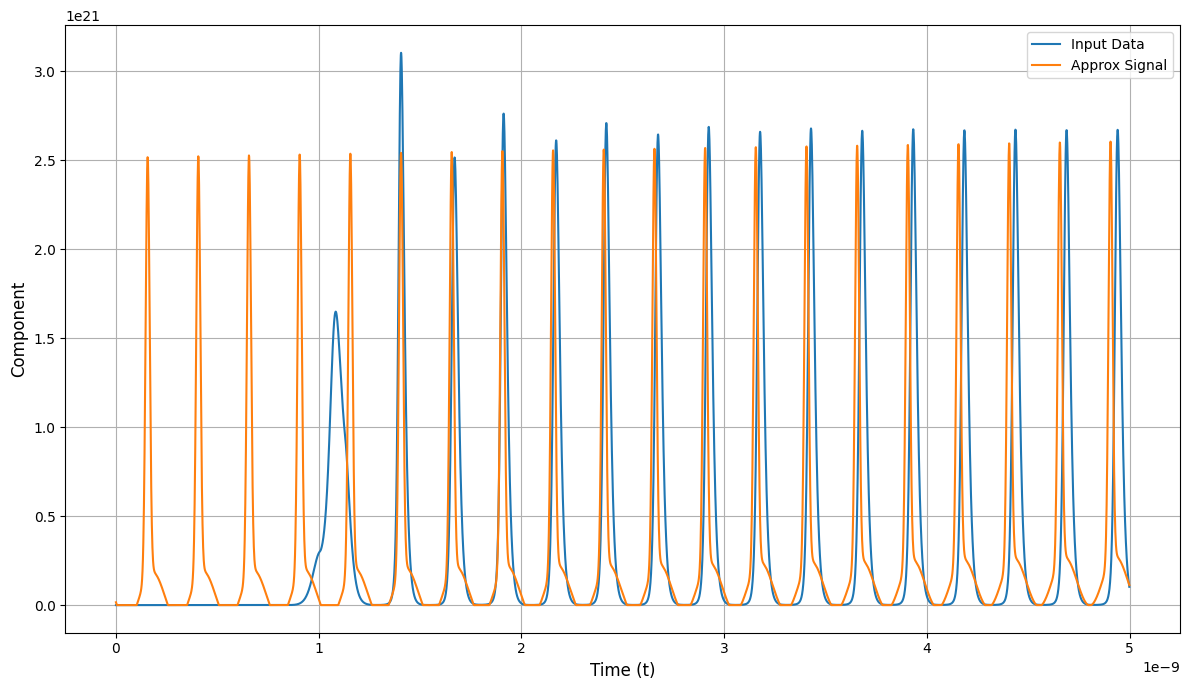

In [16]:
laser_analyser.plot_approx(photons, Coeffs_S)
#laser_analyser.plot_approx(carriers, Coeffs_N)
#laser_analyser.plot_approx(phases, Coeffs_Phi, False)

master_photons = list(photons)

### Component classes

In [17]:
class OpticalAttenuator:
    def __init__(self, laser: Laser, loss_factor= 0.0):
        self.laser = laser
        self.loss_factor = loss_factor


### Optical Injection locking
Using a master laser to lock a slave laser

In [18]:
class SlaveLaser(Laser):
    """
    Slave Laser class
    Parent: Laser class
    """

    def __init__(self, fr_freq=0, N0=N_transparent, S0=0.001, Phi0=0.001):
        super().__init__(fr_freq, N0, S0, Phi0)
        self.master_laser = None

    def set_master_laser(self, master_laser: Laser):
        """
        Set stabilised master laser
        """
        self.master_laser = master_laser
        
        self.Delta_Winj = self.fr_freq - master_laser.fr_freq
        """ frequency detuning """

    def DeltaPhi_inj(self, t):
        """
        Phase Injection
        """
        if(self.master_laser is not None):
            return self.Phi_t - self.master_laser.Phi(t)
        return 0

    def update(self, I_t, t, dt= 1e-3, Fn_t= 0.0, Fs_t= 0.0, Fphi_t= 0.0):
        """
        Update N, S, phi for slave laser and return current value
        """
        # Optical Injection Lock Terms
        if(self.master_laser is not None):
            self.N_t += self.dN_dt(I_t, Fn_t) * dt 
            self.S_t += (self.dS_dt(Fs_t) + 2 * Kappa * np.sqrt(self.master_laser.S(t) * self.S_t) * np.cos(self.DeltaPhi_inj(t) - self.Delta_Winj * t)) * dt
            
            # Non-negative and non-zero for Phase terms
            self.S_t = max(self.S_t, err_fault)
            
            self.Phi_t += (self.dPhi_dt(Fphi_t) - Kappa * np.sqrt(self.master_laser.S(t) / self.S_t) * np.sin(self.DeltaPhi_inj(t) - self.Delta_Winj * t)) * dt
        else:
            return super().update(I_t, t, dt, Fn_t, Fs_t, Fphi_t)
        return self.values()
    
Laser_freq = universalConstants.c.value / (1550 * 1e-9)

slave_laser = SlaveLaser(Laser_freq)
slave_current = CurrentDriver()

In [19]:
print(f"Threshold Current = { I_th :2.4f} Amps")
slave_current.set_Current(0.015)

# free running
slave_laser_simulator = LaserSimulator()
#laser_simulator.set_Parameters(1.0e-9, 1.0e-12)
#laser_simulator.simulate(slave_laser, slave_current)

print("Stabilized master laser:", master_laser.stable)
slave_laser.set_master_laser(master_laser)

slave_laser_simulator.set_Parameters(5.0e-9, 1.0e-12)
slave_laser_simulator.simulate(slave_laser, slave_current)

Threshold Current = 0.0178 Amps
Stabilized master laser: True
No. of samples 4999


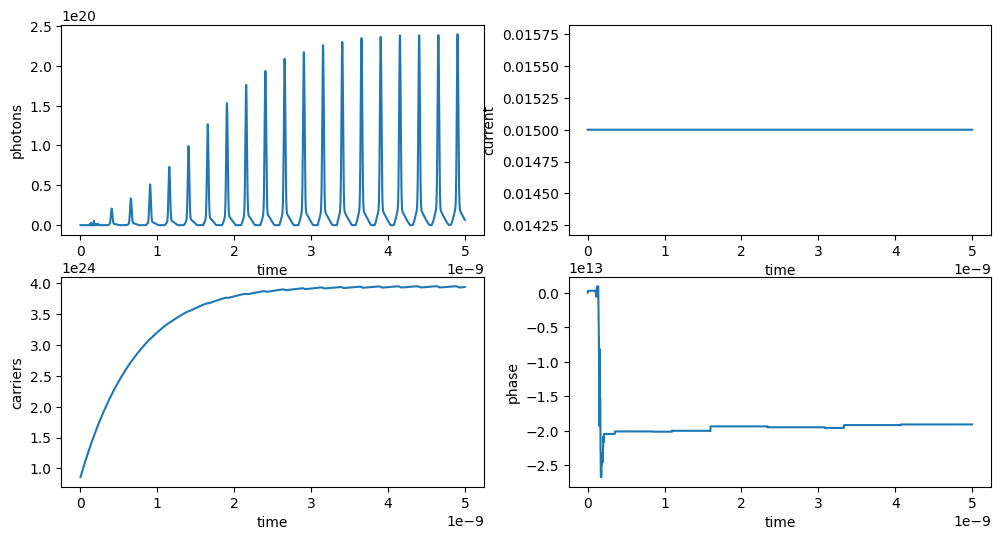

In [20]:
# Slave laser outputs
slave_laser_simulator.plot_data()
_, slave_photons, _, time = slave_laser_simulator.values()

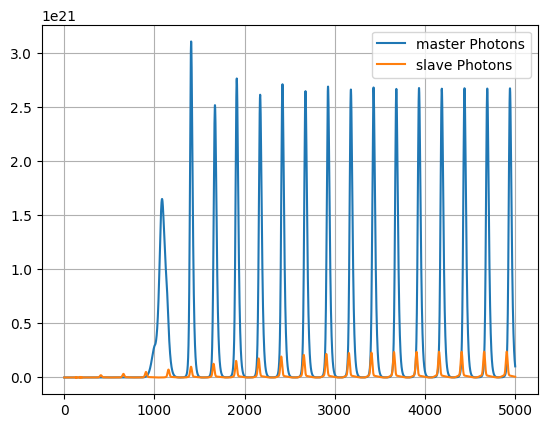

In [21]:
plt.Figure(figsize=(12,6))
plt.plot(master_photons,label= "master Photons")
plt.plot(slave_photons,label= "slave Photons")
plt.grid()
plt.legend()
plt.show()

No. of samples 1000


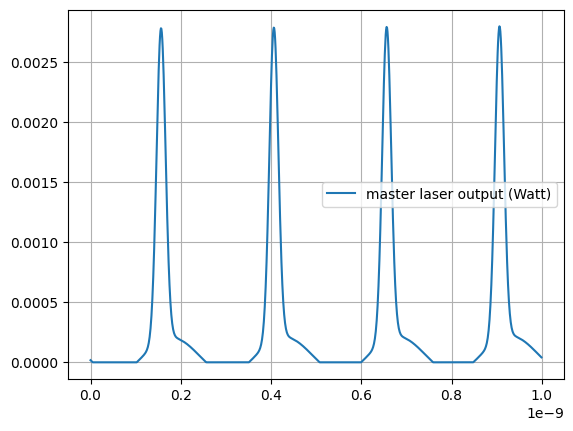

In [22]:
power, time = laser_simulator.simulate_power(master_laser, 1e-9, 1e-12)
plt.Figure(figsize=(12,6))
plt.plot(time, power,label= "master laser output (Watt)")
plt.grid()
plt.legend()
plt.show()